# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import accuracy_fn, cohen_kappa_fn
from models import EnhancedCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("../images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

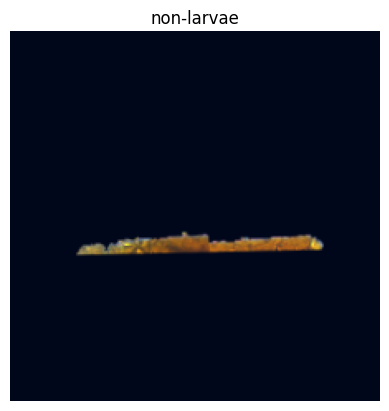

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="residual",
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
            Conv2d-4          [-1, 8, 224, 224]             584
       BatchNorm2d-5          [-1, 8, 224, 224]              16
              ReLU-6          [-1, 8, 224, 224]               0
            Conv2d-7          [-1, 8, 224, 224]             584
       BatchNorm2d-8          [-1, 8, 224, 224]              16
              ReLU-9          [-1, 8, 224, 224]               0
    ResidualBlock-10          [-1, 8, 224, 224]               0
        MaxPool2d-11          [-1, 8, 112, 112]               0
           Conv2d-12         [-1, 16, 112, 112]           1,168
      BatchNorm2d-13         [-1, 16, 112, 112]              32
             ReLU-14         [-1, 16, 1

In [ ]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=3e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/adv_cnn_0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6848 | Val Loss: 0.6546 | Train cohen_kappa_fn: 0.1905 | Val cohen_kappa_fn: 0.0143 | Train accuracy_fn: 0.7672 | Val accuracy_fn: 0.7900
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5665 | Val Loss: 0.5905 | Train cohen_kappa_fn: 0.2705 | Val cohen_kappa_fn: 0.1058 | Train accuracy_fn: 0.6258 | Val accuracy_fn: 0.5298
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5092 | Val Loss: 0.5496 | Train cohen_kappa_fn: 0.3970 | Val cohen_kappa_fn: 0.2766 | Train accuracy_fn: 0.7922 | Val accuracy_fn: 0.8182
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4539 | Val Loss: 0.5173 | Train cohen_kappa_fn: 0.5037 | Val cohen_kappa_fn: 0.4350 | Train accuracy_fn: 0.8411 | Val accuracy_fn: 0.8809
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4961 | Val Loss: 0.6226 | Train cohen_kappa_fn: 0.5071 | Val cohen_kappa_fn: 0.3726 | Train accuracy_fn: 0.8698 | Val accuracy_fn: 0.8621
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3919 | Val Loss: 0.4095 | Train cohen_kappa_fn: 0.3972 | Val cohen_kappa_fn: 0.3303 | Train accuracy_fn: 0.7297 | Val accuracy_fn: 0.6991
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3855 | Val Loss: 0.3705 | Train cohen_kappa_fn: 0.6972 | Val cohen_kappa_fn: 0.6797 | Train accuracy_fn: 0.9111 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2987 | Val Loss: 0.3059 | Train cohen_kappa_fn: 0.6763 | Val cohen_kappa_fn: 0.7256 | Train accuracy_fn: 0.8936 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2621 | Val Loss: 0.3024 | Train cohen_kappa_fn: 0.4066 | Val cohen_kappa_fn: 0.4451 | Train accuracy_fn: 0.7284 | Val accuracy_fn: 0.7931
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2630 | Val Loss: 0.2924 | Train cohen_kappa_fn: 0.7438 | Val cohen_kappa_fn: 0.7609 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.9404
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2345 | Val Loss: 0.5761 | Train cohen_kappa_fn: 0.1891 | Val cohen_kappa_fn: 0.2102 | Train accuracy_fn: 0.5106 | Val accuracy_fn: 0.5580
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2126 | Val Loss: 0.3585 | Train cohen_kappa_fn: 0.8461 | Val cohen_kappa_fn: 0.7918 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9561
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2082 | Val Loss: 0.2554 | Train cohen_kappa_fn: 0.5980 | Val cohen_kappa_fn: 0.5526 | Train accuracy_fn: 0.8511 | Val accuracy_fn: 0.8433
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2096 | Val Loss: 0.2128 | Train cohen_kappa_fn: 0.6690 | Val cohen_kappa_fn: 0.6897 | Train accuracy_fn: 0.8849 | Val accuracy_fn: 0.9122
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1721 | Val Loss: 0.2661 | Train cohen_kappa_fn: 0.8503 | Val cohen_kappa_fn: 0.8082 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9561
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2064 | Val Loss: 0.1934 | Train cohen_kappa_fn: 0.7354 | Val cohen_kappa_fn: 0.7114 | Train accuracy_fn: 0.9124 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1527 | Val Loss: 0.2186 | Train cohen_kappa_fn: 0.8079 | Val cohen_kappa_fn: 0.7860 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1423 | Val Loss: 0.3158 | Train cohen_kappa_fn: 0.8883 | Val cohen_kappa_fn: 0.8004 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9561
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1568 | Val Loss: 0.4897 | Train cohen_kappa_fn: 0.8478 | Val cohen_kappa_fn: 0.7918 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9561
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1555 | Val Loss: 0.3410 | Train cohen_kappa_fn: 0.8568 | Val cohen_kappa_fn: 0.7764 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9498
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1589 | Val Loss: 0.2501 | Train cohen_kappa_fn: 0.8570 | Val cohen_kappa_fn: 0.7738 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


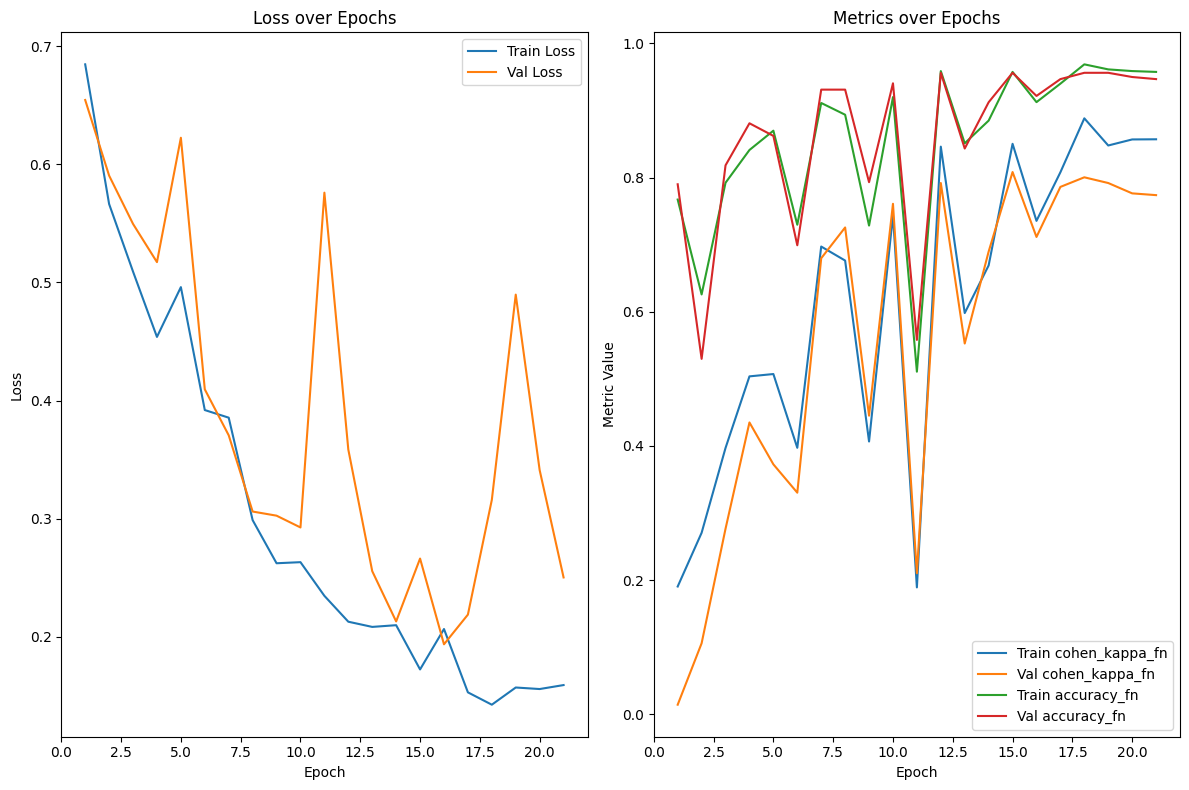

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
test_loss, test_metrics = trainer_cnn_0.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_0.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.2843 | Test cohen_kappa_fn: 0.8498 | Test accuracy_fn: 0.9646


### 3.3. CNN1

In [14]:
cnn_1 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="inception",
)
summary(cnn_1, input_shape)

RuntimeError: Given groups=1, weight of size [4, 32, 1, 1], expected input[1, 8, 112, 112] to have 32 channels, but got 8 channels instead

In [ ]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=3e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/adv_cnn_1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [ ]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7338 | Val Loss: 0.5784 | Train cohen_kappa_fn: 0.2152 | Val cohen_kappa_fn: 0.2954 | Train accuracy_fn: 0.6395 | Val accuracy_fn: 0.7962
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5849 | Val Loss: 0.5848 | Train cohen_kappa_fn: 0.2535 | Val cohen_kappa_fn: 0.2171 | Train accuracy_fn: 0.6258 | Val accuracy_fn: 0.6583
  ❄️ Performance droped, model won't be saved!


📘 Epoch 3 | Train Loss: 0.5310 | Val Loss: 0.5861 | Train cohen_kappa_fn: 0.1642 | Val cohen_kappa_fn: 0.1198 | Train accuracy_fn: 0.5044 | Val accuracy_fn: 0.4922
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.5356 | Val Loss: 0.5641 | Train cohen_kappa_fn: 0.2179 | Val cohen_kappa_fn: 0.1617 | Train accuracy_fn: 0.5845 | Val accuracy_fn: 0.5799
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5787 | Val Loss: 0.5798 | Train cohen_kappa_fn: 0.1967 | Val cohen_kappa_fn: 0.2053 | Train accuracy_fn: 0.5319 | Val accuracy_fn: 0.5893
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5108 | Val Loss: 0.5842 | Train cohen_kappa_fn: 0.3030 | Val cohen_kappa_fn: 0.1082 | Train accuracy_fn: 0.6984 | Val accuracy_fn: 0.5392
  ❄️ Performance droped, model won't be saved!


📘 Epoch 7 | Train Loss: 0.4925 | Val Loss: 0.5594 | Train cohen_kappa_fn: 0.4657 | Val cohen_kappa_fn: 0.3303 | Train accuracy_fn: 0.8686 | Val accuracy_fn: 0.8840
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5236 | Val Loss: 0.4508 | Train cohen_kappa_fn: 0.3366 | Val cohen_kappa_fn: 0.3807 | Train accuracy_fn: 0.7084 | Val accuracy_fn: 0.7712
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4826 | Val Loss: 0.4680 | Train cohen_kappa_fn: 0.4911 | Val cohen_kappa_fn: 0.6056 | Train accuracy_fn: 0.8461 | Val accuracy_fn: 0.9185
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.5117 | Val Loss: 0.4957 | Train cohen_kappa_fn: 0.4518 | Val cohen_kappa_fn: 0.5454 | Train accuracy_fn: 0.8360 | Val accuracy_fn: 0.9091
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.4555 | Val Loss: 0.4639 | Train cohen_kappa_fn: 0.4320 | Val cohen_kappa_fn: 0.4509 | Train accuracy_fn: 0.7897 | Val accuracy_fn: 0.8339
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4481 | Val Loss: 0.4904 | Train cohen_kappa_fn: 0.5353 | Val cohen_kappa_fn: 0.3052 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.7712
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4424 | Val Loss: 0.4706 | Train cohen_kappa_fn: 0.4047 | Val cohen_kappa_fn: 0.2962 | Train accuracy_fn: 0.7572 | Val accuracy_fn: 0.6708
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


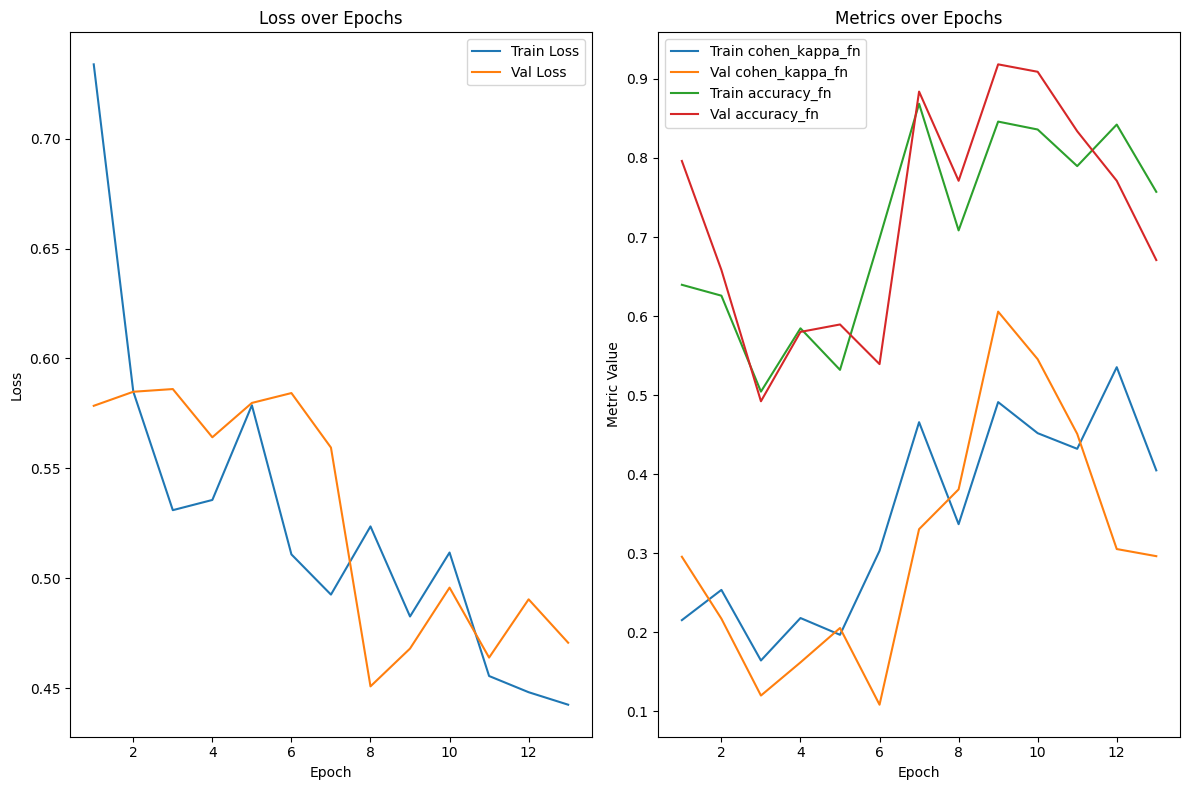

In [ ]:
trainer_cnn_1.plot_epochs()

In [ ]:
test_loss, test_metrics = trainer_cnn_1.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_1.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.4711 | Test cohen_kappa_fn: 0.3233 | Test accuracy_fn: 0.7063


### 3.4. CNN2

In [15]:
cnn_2 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
 AdaptiveAvgPool2d-3              [-1, 8, 1, 1]               0
            Linear-4                    [-1, 0]               0
              ReLU-5                    [-1, 0]               0
            Linear-6                    [-1, 8]               8
           Sigmoid-7                    [-1, 8]               0
           SEBlock-8          [-1, 8, 224, 224]               0
         MaxPool2d-9          [-1, 8, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]           1,168
             ReLU-11         [-1, 16, 112, 112]               0
AdaptiveAvgPool2d-12             [-1, 16, 1, 1]               0
           Linear-13                    [-1, 1]              17
             ReLU-14                   

/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=3e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/adv_cnn_2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [17]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6980 | Val Loss: 0.6967 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.1652 | Val accuracy_fn: 0.1411
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6929 | Val Loss: 0.6901 | Train cohen_kappa_fn: 0.1142 | Val cohen_kappa_fn: 0.0673 | Train accuracy_fn: 0.7972 | Val accuracy_fn: 0.8495
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 3 | Train Loss: 0.6913 | Val Loss: 0.6872 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8348 | Val accuracy_fn: 0.8589
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6822 | Val Loss: 0.6718 | Train cohen_kappa_fn: 0.2027 | Val cohen_kappa_fn: 0.0513 | Train accuracy_fn: 0.5970 | Val accuracy_fn: 0.5737
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6556 | Val Loss: 0.6453 | Train cohen_kappa_fn: 0.1471 | Val cohen_kappa_fn: 0.0802 | Train accuracy_fn: 0.5181 | Val accuracy_fn: 0.5266
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6076 | Val Loss: 0.6297 | Train cohen_kappa_fn: 0.1772 | Val cohen_kappa_fn: 0.0598 | Train accuracy_fn: 0.5407 | Val accuracy_fn: 0.5204
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5893 | Val Loss: 0.6569 | Train cohen_kappa_fn: 0.2068 | Val cohen_kappa_fn: 0.0293 | Train accuracy_fn: 0.6809 | Val accuracy_fn: 0.6708
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5443 | Val Loss: 0.6222 | Train cohen_kappa_fn: 0.2219 | Val cohen_kappa_fn: 0.0484 | Train accuracy_fn: 0.6145 | Val accuracy_fn: 0.5831
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5432 | Val Loss: 0.6113 | Train cohen_kappa_fn: 0.1787 | Val cohen_kappa_fn: 0.1477 | Train accuracy_fn: 0.5119 | Val accuracy_fn: 0.5172
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5362 | Val Loss: 0.6126 | Train cohen_kappa_fn: 0.2373 | Val cohen_kappa_fn: 0.0648 | Train accuracy_fn: 0.6145 | Val accuracy_fn: 0.6050
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.5054 | Val Loss: 0.6011 | Train cohen_kappa_fn: 0.2279 | Val cohen_kappa_fn: 0.1060 | Train accuracy_fn: 0.5832 | Val accuracy_fn: 0.5862
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.5303 | Val Loss: 0.5760 | Train cohen_kappa_fn: 0.2607 | Val cohen_kappa_fn: 0.1362 | Train accuracy_fn: 0.6183 | Val accuracy_fn: 0.6332
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.5315 | Val Loss: 0.5775 | Train cohen_kappa_fn: 0.2152 | Val cohen_kappa_fn: 0.1555 | Train accuracy_fn: 0.5632 | Val accuracy_fn: 0.5768
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.4960 | Val Loss: 0.6668 | Train cohen_kappa_fn: 0.3072 | Val cohen_kappa_fn: 0.0752 | Train accuracy_fn: 0.6934 | Val accuracy_fn: 0.6552
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.5057 | Val Loss: 0.6034 | Train cohen_kappa_fn: 0.2382 | Val cohen_kappa_fn: 0.1425 | Train accuracy_fn: 0.5920 | Val accuracy_fn: 0.5799
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.4744 | Val Loss: 0.6254 | Train cohen_kappa_fn: 0.3015 | Val cohen_kappa_fn: 0.0928 | Train accuracy_fn: 0.6996 | Val accuracy_fn: 0.6740
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.4903 | Val Loss: 0.7093 | Train cohen_kappa_fn: 0.4179 | Val cohen_kappa_fn: 0.1376 | Train accuracy_fn: 0.8073 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


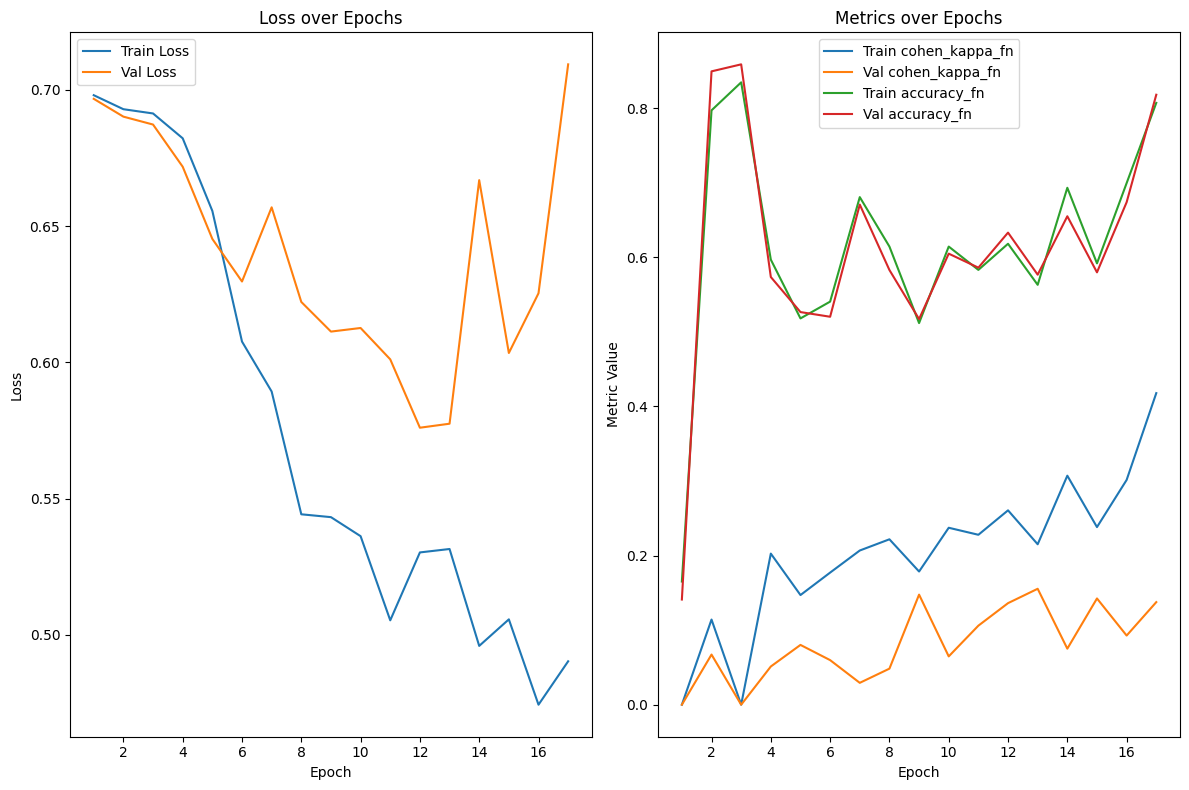

In [18]:
trainer_cnn_2.plot_epochs()

In [19]:
test_loss, test_metrics = trainer_cnn_2.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_2.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.6824 | Test cohen_kappa_fn: 0.0269 | Test accuracy_fn: 0.8021


### 3.5. CNN3

In [20]:
cnn_3 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
)
summary(cnn_3, input_shape)

/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: Given groups=1, expected weight to be at least 1 at dimension 0, but got weight of size [0, 8, 1, 1] instead

In [ ]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=3e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-5)
ckpt_cnn_3 = "weights/adv_cnn_3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [ ]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.7457 | Val Loss: 0.6797 | Train cohen_kappa_fn: 0.1935 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8611 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6319 | Val Loss: 0.6155 | Train cohen_kappa_fn: 0.2091 | Val cohen_kappa_fn: 0.1002 | Train accuracy_fn: 0.5920 | Val accuracy_fn: 0.5611
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5418 | Val Loss: 0.6516 | Train cohen_kappa_fn: 0.3802 | Val cohen_kappa_fn: 0.0892 | Train accuracy_fn: 0.7822 | Val accuracy_fn: 0.6614
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.4859 | Val Loss: 0.5681 | Train cohen_kappa_fn: 0.1990 | Val cohen_kappa_fn: 0.1523 | Train accuracy_fn: 0.5532 | Val accuracy_fn: 0.5204
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5238 | Val Loss: 0.5800 | Train cohen_kappa_fn: 0.3684 | Val cohen_kappa_fn: 0.2123 | Train accuracy_fn: 0.7597 | Val accuracy_fn: 0.7335
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.4796 | Val Loss: 0.5544 | Train cohen_kappa_fn: 0.4481 | Val cohen_kappa_fn: 0.2951 | Train accuracy_fn: 0.8160 | Val accuracy_fn: 0.8276
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4741 | Val Loss: 0.5246 | Train cohen_kappa_fn: 0.2600 | Val cohen_kappa_fn: 0.2043 | Train accuracy_fn: 0.6195 | Val accuracy_fn: 0.5799
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4689 | Val Loss: 0.4900 | Train cohen_kappa_fn: 0.2111 | Val cohen_kappa_fn: 0.2063 | Train accuracy_fn: 0.5532 | Val accuracy_fn: 0.5580
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4231 | Val Loss: 0.4851 | Train cohen_kappa_fn: 0.2498 | Val cohen_kappa_fn: 0.2265 | Train accuracy_fn: 0.5982 | Val accuracy_fn: 0.5831
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4319 | Val Loss: 0.4875 | Train cohen_kappa_fn: 0.4476 | Val cohen_kappa_fn: 0.3713 | Train accuracy_fn: 0.7960 | Val accuracy_fn: 0.7649
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3804 | Val Loss: 0.4292 | Train cohen_kappa_fn: 0.3950 | Val cohen_kappa_fn: 0.3649 | Train accuracy_fn: 0.7522 | Val accuracy_fn: 0.7398
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3701 | Val Loss: 0.4619 | Train cohen_kappa_fn: 0.3789 | Val cohen_kappa_fn: 0.2642 | Train accuracy_fn: 0.7259 | Val accuracy_fn: 0.6395
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3877 | Val Loss: 0.3675 | Train cohen_kappa_fn: 0.5086 | Val cohen_kappa_fn: 0.4919 | Train accuracy_fn: 0.8210 | Val accuracy_fn: 0.8213
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3624 | Val Loss: 0.3544 | Train cohen_kappa_fn: 0.5753 | Val cohen_kappa_fn: 0.5681 | Train accuracy_fn: 0.8573 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3514 | Val Loss: 0.3717 | Train cohen_kappa_fn: 0.5243 | Val cohen_kappa_fn: 0.3868 | Train accuracy_fn: 0.8223 | Val accuracy_fn: 0.7461
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3263 | Val Loss: 0.3643 | Train cohen_kappa_fn: 0.5555 | Val cohen_kappa_fn: 0.4523 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.8025
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3065 | Val Loss: 0.3370 | Train cohen_kappa_fn: 0.5410 | Val cohen_kappa_fn: 0.4400 | Train accuracy_fn: 0.8348 | Val accuracy_fn: 0.7868
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2902 | Val Loss: 0.2814 | Train cohen_kappa_fn: 0.5982 | Val cohen_kappa_fn: 0.5862 | Train accuracy_fn: 0.8698 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3014 | Val Loss: 0.3433 | Train cohen_kappa_fn: 0.6754 | Val cohen_kappa_fn: 0.4854 | Train accuracy_fn: 0.9049 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3144 | Val Loss: 0.3021 | Train cohen_kappa_fn: 0.6885 | Val cohen_kappa_fn: 0.6092 | Train accuracy_fn: 0.9036 | Val accuracy_fn: 0.8809
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.3016 | Val Loss: 0.3295 | Train cohen_kappa_fn: 0.6249 | Val cohen_kappa_fn: 0.4542 | Train accuracy_fn: 0.8711 | Val accuracy_fn: 0.7837
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2658 | Val Loss: 0.2774 | Train cohen_kappa_fn: 0.7111 | Val cohen_kappa_fn: 0.5725 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8621
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2729 | Val Loss: 0.3036 | Train cohen_kappa_fn: 0.6559 | Val cohen_kappa_fn: 0.4887 | Train accuracy_fn: 0.8874 | Val accuracy_fn: 0.8088
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2770 | Val Loss: 0.2968 | Train cohen_kappa_fn: 0.6339 | Val cohen_kappa_fn: 0.5105 | Train accuracy_fn: 0.8761 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2598 | Val Loss: 0.3535 | Train cohen_kappa_fn: 0.5740 | Val cohen_kappa_fn: 0.3633 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.7179
  ❄️ Performance droped, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2417 | Val Loss: 0.4473 | Train cohen_kappa_fn: 0.5897 | Val cohen_kappa_fn: 0.2931 | Train accuracy_fn: 0.8523 | Val accuracy_fn: 0.6489
  ❄️ Performance droped, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2188 | Val Loss: 0.2600 | Train cohen_kappa_fn: 0.7280 | Val cohen_kappa_fn: 0.5651 | Train accuracy_fn: 0.9186 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2392 | Val Loss: 0.2625 | Train cohen_kappa_fn: 0.7112 | Val cohen_kappa_fn: 0.5919 | Train accuracy_fn: 0.9124 | Val accuracy_fn: 0.8683
  ❄️ Performance droped, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2697 | Val Loss: 0.2918 | Train cohen_kappa_fn: 0.7212 | Val cohen_kappa_fn: 0.5217 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8307
  ❄️ Performance droped, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2420 | Val Loss: 0.2483 | Train cohen_kappa_fn: 0.7274 | Val cohen_kappa_fn: 0.6131 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8777
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2291 | Val Loss: 0.2689 | Train cohen_kappa_fn: 0.7432 | Val cohen_kappa_fn: 0.5518 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2298 | Val Loss: 0.2770 | Train cohen_kappa_fn: 0.7650 | Val cohen_kappa_fn: 0.5576 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2029 | Val Loss: 0.2496 | Train cohen_kappa_fn: 0.7552 | Val cohen_kappa_fn: 0.6329 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2256 | Val Loss: 0.2291 | Train cohen_kappa_fn: 0.7158 | Val cohen_kappa_fn: 0.6581 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.2034 | Val Loss: 0.2581 | Train cohen_kappa_fn: 0.7418 | Val cohen_kappa_fn: 0.5765 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8558
  ❄️ Performance droped, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1874 | Val Loss: 0.2549 | Train cohen_kappa_fn: 0.7404 | Val cohen_kappa_fn: 0.5830 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8589
  ❄️ Performance droped, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2189 | Val Loss: 0.2452 | Train cohen_kappa_fn: 0.7866 | Val cohen_kappa_fn: 0.5644 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.8527
  ❄️ Performance droped, model won't be saved!


📘 Epoch 38 | Train Loss: 0.2024 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.7573 | Val cohen_kappa_fn: 0.5907 | Train accuracy_fn: 0.9262 | Val accuracy_fn: 0.8652
  ❄️ Performance droped, model won't be saved!


📘 Epoch 39 | Train Loss: 0.2022 | Val Loss: 0.2595 | Train cohen_kappa_fn: 0.7465 | Val cohen_kappa_fn: 0.5644 | Train accuracy_fn: 0.9212 | Val accuracy_fn: 0.8527
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


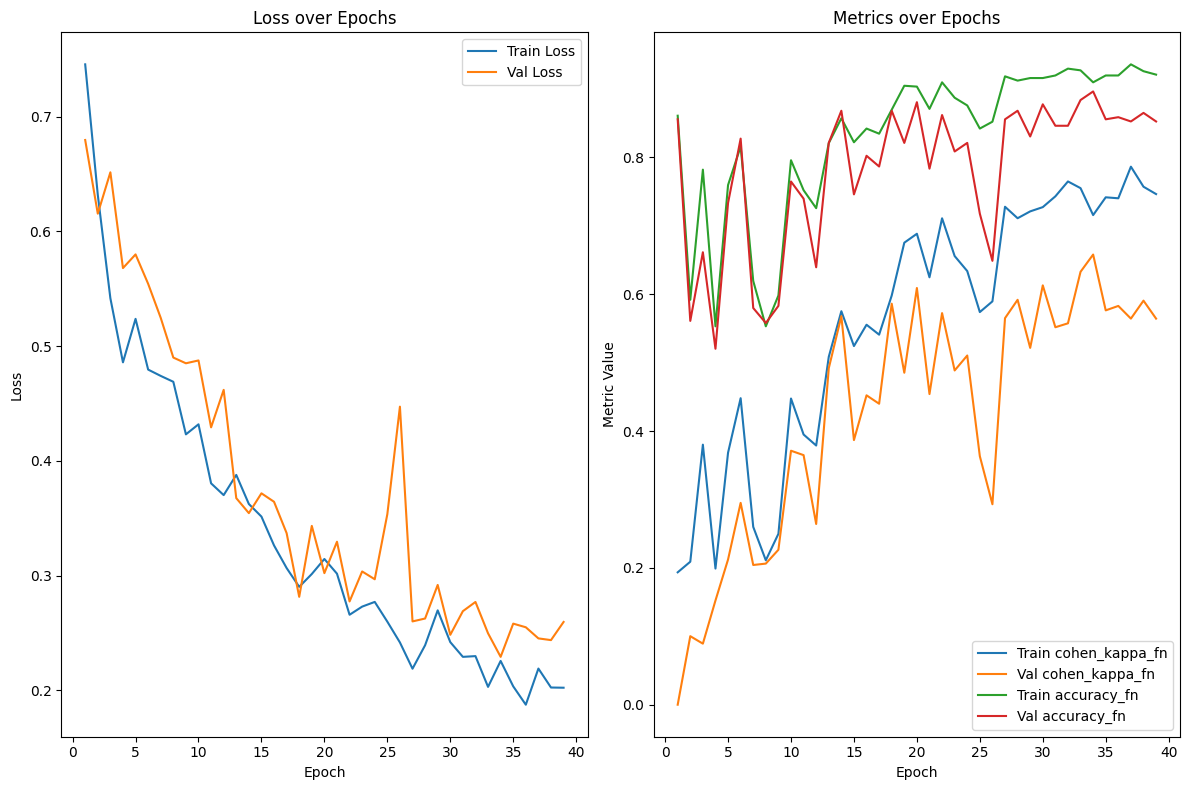

In [ ]:
trainer_cnn_3.plot_epochs()

In [ ]:
test_loss, test_metrics = trainer_cnn_3.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_3.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.2485 | Test cohen_kappa_fn: 0.6350 | Test accuracy_fn: 0.8771
